# AuxTel test LTS-337-016 (Tracking)

*** 

In this notebook, we check the tracking accuracy of the telescope by taking a series of images over a 10 minute period.  Desired specs:

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The Auxiliary Telescope shall have a open-loop tracking accuracy over a 10 minute interval within the tracking range of:     | 2.0       | Arcsec RMS   |Aux_Tel_Tel_Track_Error|
The Auxiliary Telescope shall have the ability to track for a minimum time of: | 10| Minutes |Aux_Tel_Max_track_time|
|The Auxiliary Telescope shall be able to track in azimuth over the angular range of:|+/- 270       | Degrees     |Aux_Tel_Az_Track_Range|
|Tracking Range in elevation shall be at least:   | 20-86.5|Degrees|Aux_Tel_El_Track_Range_High|


***

Added October Tracking Tests- Tracking tests 2021/10 Observing Run (254-273 (70 degrees EL) &  275-294 (60 degrees EL))

Modified for Gen3 Butler. 

Oct/26th - Can't access NCSA yet. So have to execute two different ones for September and October observing runs. 
Oct/27th - No quickLookExp available at the summit, nor 'bias' collection to run ISR task. Merlin's is looking into that. Notebook modified to distribute.

In [1]:
import sys, time, os, asyncio
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u


import lsst.daf.butler as dafButler

from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
from lsst.rapid.analysis.bestEffort import BestEffortIsr


/home/isotuela/auto-op-env-packages/rapid_analysis/python/lsst/rapid/analysis/visitCheck.py:132: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def runDataRef(self, dataRef):


In [2]:
# Set Cerro Pachon location and observation time
location = EarthLocation.from_geodetic(lon=-70.749417*u.deg,
                                       lat=-30.244639*u.deg,
                                       height=2663.0*u.m)

In [3]:
REPO_DIR = '/repo/LATISS'
butler = dafButler.Butler(REPO_DIR, instrument='LATISS', collections = 'LATISS/raw/all')

***
Define the tracking test by constructing a list in which each element is an individual tracking test that contains two elements, the first sequence of the test and the number of images. The number of images might be different from test to test due to different exposure times. 

| Tracking Test | First Sequence       | Number of images          |  
| :---        |    :----:   |       ----:  |    
|September Run 1  | 2021090700360       |  34 |
|September Run 2  | 2021090700400       |  34 |
|September Run 3  | 2021090700454       |  34 |
|September Run 4  | 2021090700493       |  34 |
|September Run 5  | 2021090700534       |  34 |
|September Run 6  | 2021090700573       |  34 |
|September Run 7  | 2021090800263       |  34 |
|September Run 8  | 2021090800324       |  34 |
|October Run 1  | 2021100500254       |  20 |
|October Run 2  | 2021100500275       |  20 |
|November Run 1 (Az) | 2021110300350       |  41 |
|November Run 2 (Az) | 2021110300393       |  44 |
|November Run 3 (Pole)| 2021110400614            |  239 |
|November Run 4 (El)  | 2021110400855      | 72 |




In [3]:
#trackingTests = [[2021090700360,34], [2021090700400, 34], [2021090700454, 34], [2021090700493, 34], [2021090700534, 34], [2021090700573, 34], [2021090800263, 34], [2021090800324, 34], [2021100500254, 20], [2021100500275, 20], [2021110300350, 41] , 2021110300393, 44], [2021110400614, 239], [2021110400855, 72]]
trackingTests = [[2021100500254, 20], [2021100500275, 20]]

Object `client.select_packed_time_series` not found.


*** 
Define the plate scale. 

In [4]:
# Instantiate and config the tasks
bestEffort = BestEffortIsr('/repo/LATISS')

qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

In [5]:
dayObs = 20211005
seqNum = 254

data_id = {'instrument': 'LATISS', 'exposure': 2021100500254 , 'detector':0}

exp_BestEffort = bestEffort.getExposure(data_id)
# Measure Centroids
result = qm.run(exp_BestEffort)
centroids = result.brightestObjCentroid
print(centroids)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-29-g401bd7c4+5f62c5d854/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


(2074.5064058308362, 2068.7146578590637)


In [9]:
# Define the plate scale
plateScale = exp_BestEffort.getWcs().getPixelScale().asArcseconds() # arcseconds/pixel
print(plateScale)
print('The plate scale is %f'%(plateScale))

0.09569499991058202
The plate scale is 0.095695


#### 1. Extract metadata (ELSTART, AZSTART, DECSTART, RASTART, ROTPA, DATE-BEG, DATE-END, OBJECT) from the image headers for each image taken during the 10-min tracking time. Write the results in a dictionary posData.  

In [11]:
posData = {}

for firstExpId in trackingTests:
    print('Starting with', firstExpId[0])
    data = {}
    centroids = []
    els = []
    azs = []
    decs = []
    ras = []
    rotpas = []
    tStart = []
    tEnd = []
    source = []

    numExp = firstExpId[1]
    for i in range(numExp):
        expId = firstExpId[0] + i
        data_id = {'instrument': 'LATISS', 'exposure': expId , 'detector':0}
        exp_BestEffort = bestEffort.getExposure(data_id)
        result = qm.run(exp_BestEffort)
        centroids.append(result.brightestObjCentroid)
        mData = exp_BestEffort.getMetadata()
        els.append(mData['ELSTART'])
        azs.append(mData['AZSTART'])
        decs.append(mData['DECSTART'])
        ras.append(mData['RASTART'])
        rotpas.append(mData['ROTPA'])
        tStart.append(mData['DATE-BEG'])
        tEnd.append(mData['DATE-END'])
        source.append(mData['OBJECT'])
    data['Elevation'] = els
    data['Azimuth'] = azs
    data['Dec'] = decs
    data['RA'] = ras
    data['ROTPA'] = rotpas
    data['Centroids'] = centroids
    data['StartTime'] = tStart
    data['EndTime'] = tEnd
    data['Source'] = source
    posData[firstExpId[0]] = data

Starting with 2021100500254


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


Starting with 2021100500275


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


## 2. Write data into a file 

***
To save the data so you don't have to run the process again. 

In [12]:
# Introduce filename here to save:
file_Name = "10minTracking_October_bestEffortIsr"

In [13]:
import json
#json.dump(positionData, a_file)
f = open(file_Name,"w")

f.write(json.dumps(posData))

# close file
f.close()


## 3. Recover data from a file (If you have already executed Steps 1 and 2)


***
If you already have the data saved in a file, recover the data here:

In [ ]:
# Introduce filename here to recover:
file_Name = "10minTracking_October_BestEffortIsr"

In [14]:
# Recover posData dictionary from file posData_file:
import json
  
# reading the data from the file
with open(file_Name) as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
posData = json.loads(data)
  
print("Data type after reconstruction : ", type(posData))
print(posData)

Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>
{'2021100500254': {'Elevation': [68.3777617498272, 68.3612952216499, 68.3450079544418, 68.3276272400253, 68.3096068187588, 68.2912976129737, 68.2724667175644, 68.2532786412921, 68.2334624810901, 68.2133821233147, 68.1927380545822, 68.1716688557499, 68.1500194056862, 68.1281240864628, 68.1062453075283, 68.0834420605534, 68.060084490382, 68.0363518579834, 68.0119875653618, 67.9873966260639], 'Azimuth': [-172.183994273873, -171.956828604685, -171.73719860171, -171.510941307279, -171.285211961018, -171.059787939535, -170.834852080094, -170.610358338105, -170.386628131615, -170.163302938687, -169.940194110619, -169.717663298594, -169.495841930853, -169.274432729231, -169.060474704253, -168.840122740017, -168.620178471552, -168.401088486658, -168.182393680559, -167.964551816927], 'Dec': [-51.7508799868234, -51.7508512017825, -51.7507190667797, -51.750692252358, -51.7508421977605, -51.75081073442

## 4.Obtain centroids and deviation RMS for each test

In [32]:
trackingTestswithRMS = []

print(f"Tracking test \t Azimuth \t Elevation \t Duration (min) \t RMS Az \t RMS El \t RMS_tot")

for exposure in (trackingTests):
    firstExpId = str(exposure[0])
    
    # Test Duration
    start_time = Time(posData[firstExpId]['StartTime'][0], format='fits', scale='tai')
    end_time = Time(posData[firstExpId]['EndTime'][-1], format='fits', scale='tai')
    duration = TimeDelta(end_time - start_time, format='sec').value/60
    
    # Centroid and deviations x/y
    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    
    # Deviation Az/El
    el = Angle(posData[firstExpId]['Elevation'][0] * u.deg)
    az = Angle(posData[firstExpId]['Azimuth'][0] * u.deg)
    dec = Angle(posData[firstExpId]['Dec'][0] * u.deg)
    rotpa = Angle(posData[firstExpId]['ROTPA'][0] * u.deg) 
    sinTheta =  np.cos(location.lat) / np.cos(dec) * np.sin(az)
    theta = Angle(np.arcsin(sinTheta))
    rotAzEl = rotpa - theta - Angle(90.0 * u.deg) 
    rotMatrix = np.array([[np.cos(rotAzEl), -np.sin(rotAzEl)], [np.sin(rotAzEl), np.cos(rotAzEl)]])
    for i in range(len(deviation)):
        deviation[i,:] = np.dot(rotMatrix,deviation[i,:])
   
    
    # RMS
    rms = np.sqrt((deviation * deviation).mean(axis=0))
    rms_tot = np.sqrt((rms * rms).sum())
    
    # Attach RMS_tot to each tracking test and build the list again:
    trackingTestswithRMS.append([exposure[0], exposure[1], round(rms_tot,3)])
    
    print(f"{firstExpId} \t {az:.1f} \t {el:.1f} \t {duration:.2f} \t\t\t {rms[0]:.3f} \t\t {rms[1]:.3f} \t\t {rms_tot:.3f}")
    


Tracking test 	 Azimuth 	 Elevation 	 Duration (min) 	 RMS Az 	 RMS El 	 RMS_tot
2021100500254 	 -172.2 deg 	 68.4 deg 	 10.90 			 1.294 		 1.301 		 1.835
2021100500275 	 -199.1 deg 	 60.3 deg 	 10.91 			 1.473 		 0.932 		 1.744


*** 
The new list trackingTestswithRMS contains the first sequence, number of images and RMS total. 

In [33]:
trackingTestswithRMS

[[2021100500254, 20, 1.835], [2021100500275, 20, 1.744]]

##  5. Tracking errors

### 5.1. Elevation deviation vs. Azimuth Deviation

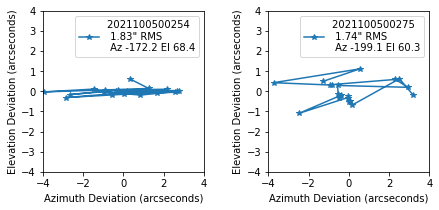

In [28]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plotcounter = 1

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
     
    plt.subplot(2,4,plotcounter, aspect=1.0)
    plt.plot(deviation[:,0], deviation[:,1], label = ('{} \n {}\" RMS \n Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = '*')
    plt.xlim(-4,4)
    plt.xlabel("Azimuth Deviation (arcseconds)")
    plt.ylim(-4,4)
    plt.ylabel("Elevation Deviation (arcseconds)")    
    plt.legend()
    plotcounter += 1
plt.savefig('Elevation vs Azimuth Deviation.jpg')

### 5.2. Azimuth Deviation vs. Azimuth

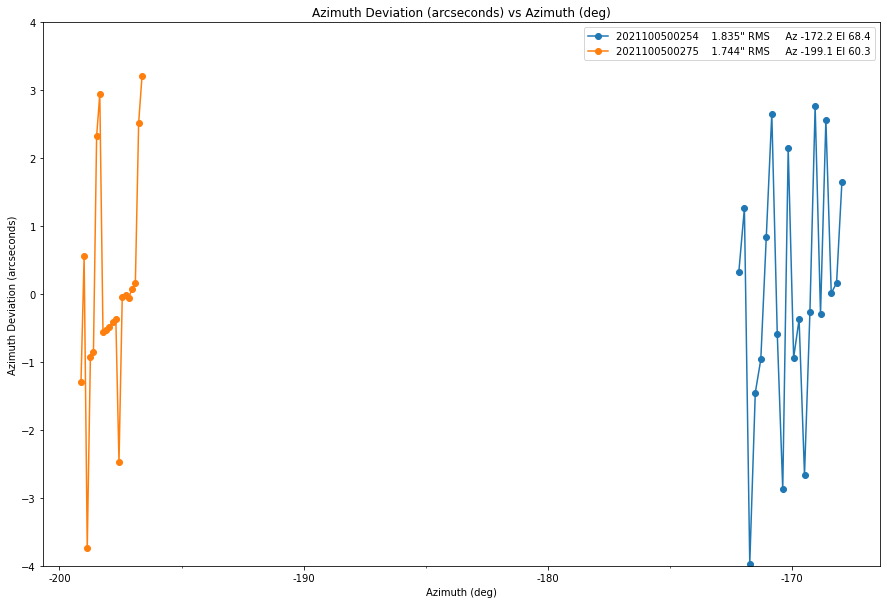

In [37]:
fig, ax = plt.subplots(figsize=(15,10))

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    
    ax.plot(posData[firstExpId]['Azimuth'],deviation[:,0], label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')
    ax.set_ylabel("Azimuth Deviation (arcseconds)")    
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylim(-4,4)
    ax.legend()
    plt.title('Azimuth Deviation (arcseconds) vs Azimuth (deg)')

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter('{x:.0f}')

    ax.xaxis.set_minor_locator(MultipleLocator(5))

plt.savefig('Azimuth Deviation vs Azimuth.jpg')

### 5.3. Elevation Deviation vs. Azimuth

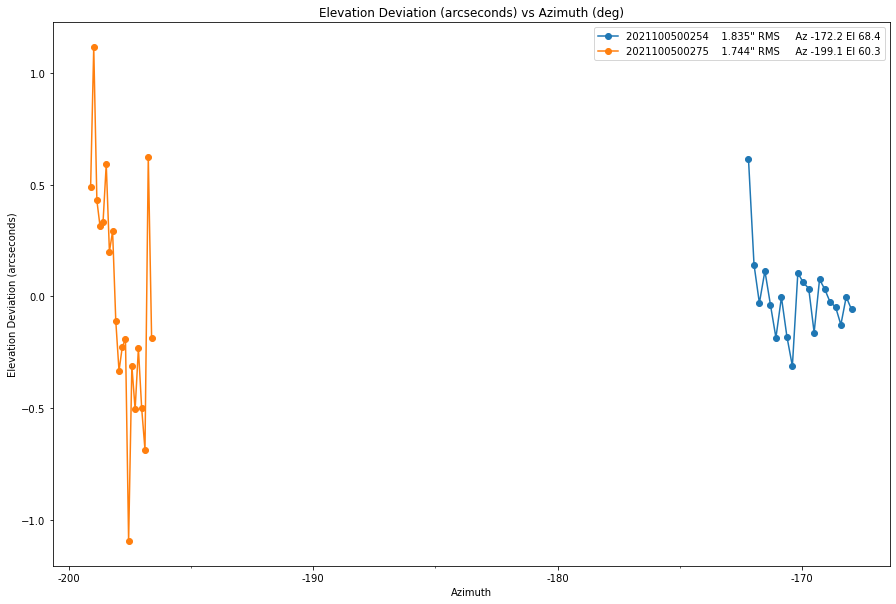

In [36]:
fig, ax = plt.subplots(figsize=(15,10))

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale

    
    ax.plot(posData[firstExpId]['Azimuth'],deviation[:,1], label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')
    ax.set_ylabel("Elevation Deviation (arcseconds)")    
    ax.set_xlabel("Azimuth")
    ax.legend()
    plt.title('Elevation Deviation (arcseconds) vs Azimuth (deg)')


    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter('{x:.0f}')

    ax.xaxis.set_minor_locator(MultipleLocator(5))
    
plt.savefig('Elevation Deviation vs Azimuth.jpg')

### 5.4. Elevation Deviation vs. Elevation

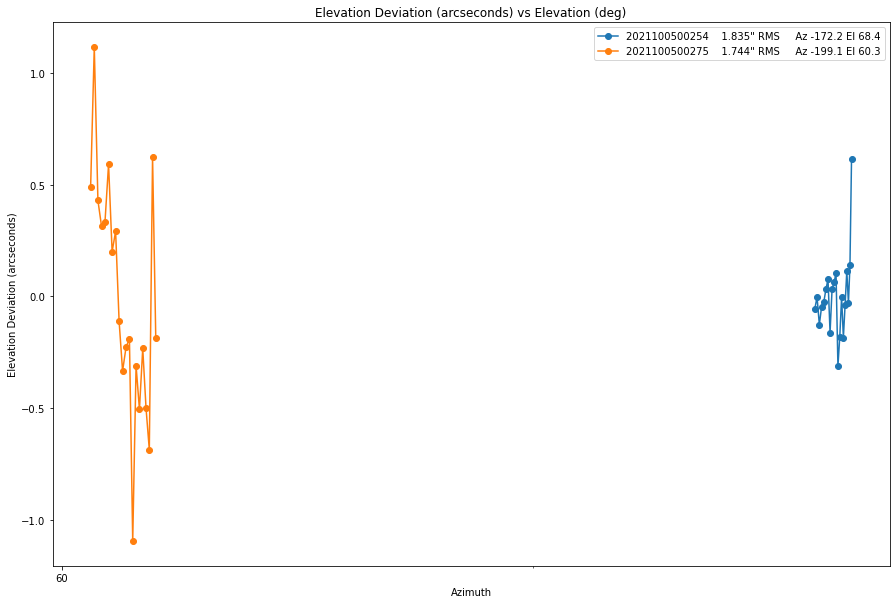

In [38]:
fig, ax = plt.subplots(figsize=(15,10))

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    
    
    ax.plot(posData[firstExpId]['Elevation'],deviation[:,1], label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')
    ax.set_ylabel("Elevation Deviation (arcseconds)")    
    ax.set_xlabel("Elevation")
    ax.legend()
    plt.title('Elevation Deviation (arcseconds) vs Elevation (deg)')


    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter('{x:.0f}')

    ax.xaxis.set_minor_locator(MultipleLocator(5))
    
plt.savefig('Elevation Deviation vs Elevation.jpg')

### 5.5. Azimuth deviation vs. tracking time

/tmp/ipykernel_4634/1583713645.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(b)
/tmp/ipykernel_4634/1583713645.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(b)


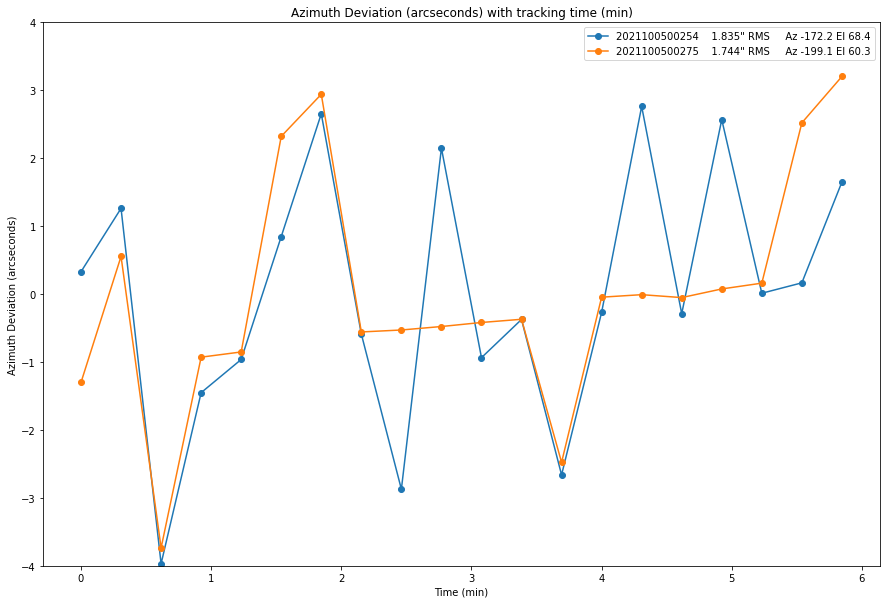

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
    
for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])
    
    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    
    ax.plot(deviation[:,0], label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')

    ax.set_ylabel("Azimuth Deviation (arcseconds)")    
    ax.set_xlabel("Time (min)")
    ax.legend()
    ax.set_ylim(-4,4)

    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3.25))
    plt.title('Azimuth Deviation (arcseconds) with tracking time (min)')
    a=ax.get_xticks().tolist()
    b = [-10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
    ax.set_xticklabels(b)

plt.savefig('Azimuth Deviation vs Time.jpg')

### 5.6 Elevation deviation vs. tracking time

/tmp/ipykernel_4634/2186190130.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
/tmp/ipykernel_4634/2186190130.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)


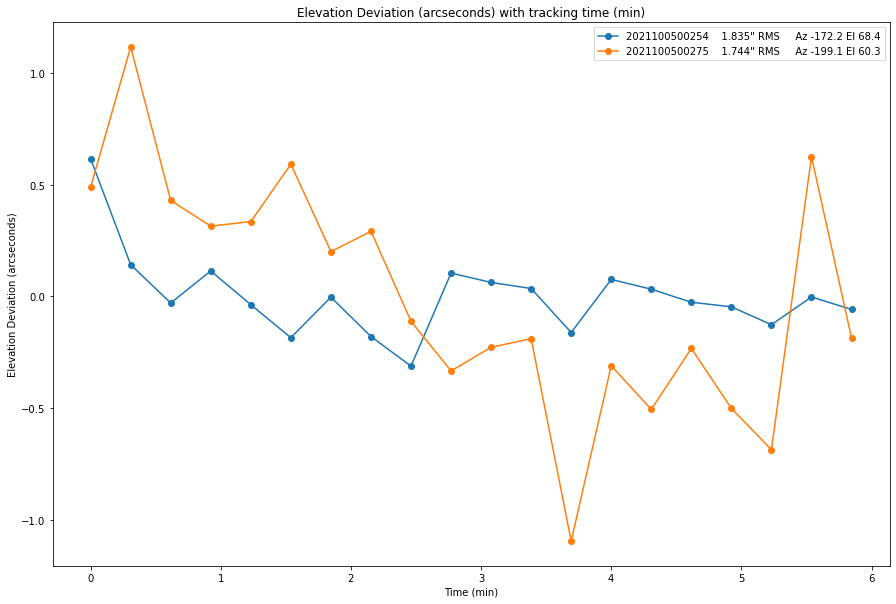

In [41]:
fig, ax = plt.subplots(figsize=(15,10))

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    centroids = np.array(posData[firstExpId]['Centroids'])
    meanPosition = centroids.mean(axis=0)
    deviation = (centroids - meanPosition) * plateScale
    
    ax.plot(deviation[:,1], label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')

    ax.set_ylabel("Elevation Deviation (arcseconds)")    
    ax.set_xlabel("Time (min)")
    ax.legend()
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3.25))
    plt.title('Elevation Deviation (arcseconds) with tracking time (min)')

    
    a=ax.get_xticks().tolist()
    a = [-99999, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 999999]
    ax.set_xticklabels(a)

plt.savefig('Elevation Deviation vs Time.jpg')

### 5.7 RA vs. DEC deviation

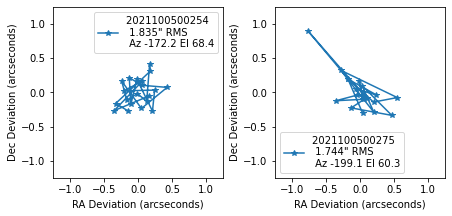

In [42]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.1,wspace=0.3)
plotcounter = 1

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    ras = np.array(posData[firstExpId]['RA'])
    decs = np.array(posData[firstExpId]['Dec'])
    meanra = ras.mean()
    meandec = decs.mean()
    ra_deviation = (ras - meanra) * 3600.0
    dec_deviation = (decs - meandec) * 3600.0
    plt.subplot(2,4,plotcounter, aspect=1.0)
    plt.plot(ra_deviation, dec_deviation, label = ('{} \n {}\" RMS \n Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))),marker ='*')
    plt.xlim(-1.25,1.25)
    plt.xlabel("RA Deviation (arcseconds)")
    plt.ylim(-1.25,1.25)
    plt.ylabel("Dec Deviation (arcseconds)")    
    plt.legend()
    plotcounter += 1

plt.savefig('Dec Deviation vs RA Deviation.jpg')

### 5.8 RA deviation vs. tracking time

/tmp/ipykernel_4634/1214674547.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
/tmp/ipykernel_4634/1214674547.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)


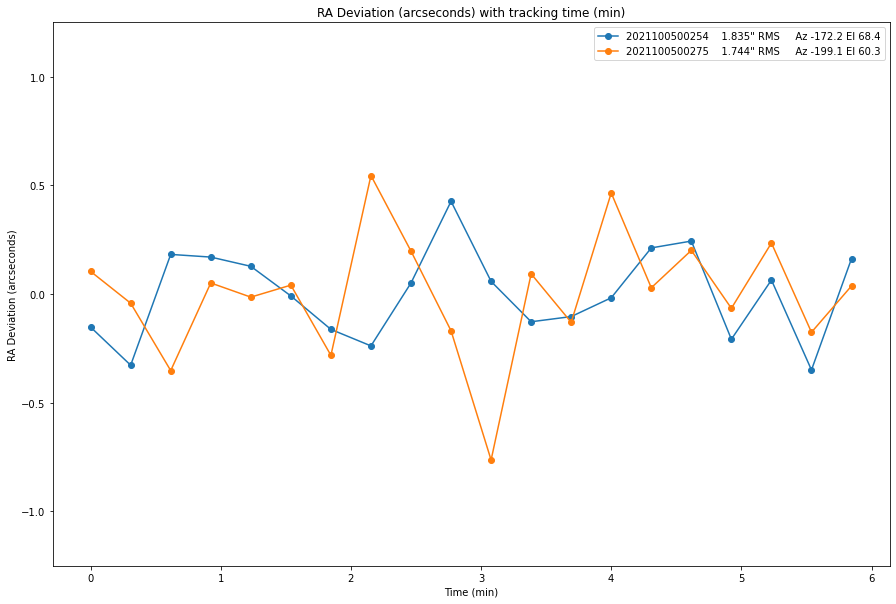

In [43]:
fig, ax = plt.subplots(figsize=(15,10))

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    ras = np.array(posData[firstExpId]['RA'])
    decs = np.array(posData[firstExpId]['Dec'])
    meanra = ras.mean()
    meandec = decs.mean()
    ra_deviation = (ras - meanra) * 3600.0
    dec_deviation = (decs - meandec) * 3600.0    
    
    ax.plot(ra_deviation, label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')
    ax.set_ylabel("RA Deviation (arcseconds)")    
    ax.set_xlabel("Time (min)")
    ax.legend()
    ax.set_ylim(-1.25,1.25)

    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3.25))
    plt.title('RA Deviation (arcseconds) with tracking time (min)')

    a=ax.get_xticks().tolist()
    a = [-99999, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 999999]
    ax.set_xticklabels(a)

plt.savefig('RA Deviation vs Time.jpg')

### 5.9. DEC deviation vs. tracking time

/tmp/ipykernel_4634/3455797196.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
/tmp/ipykernel_4634/3455797196.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)


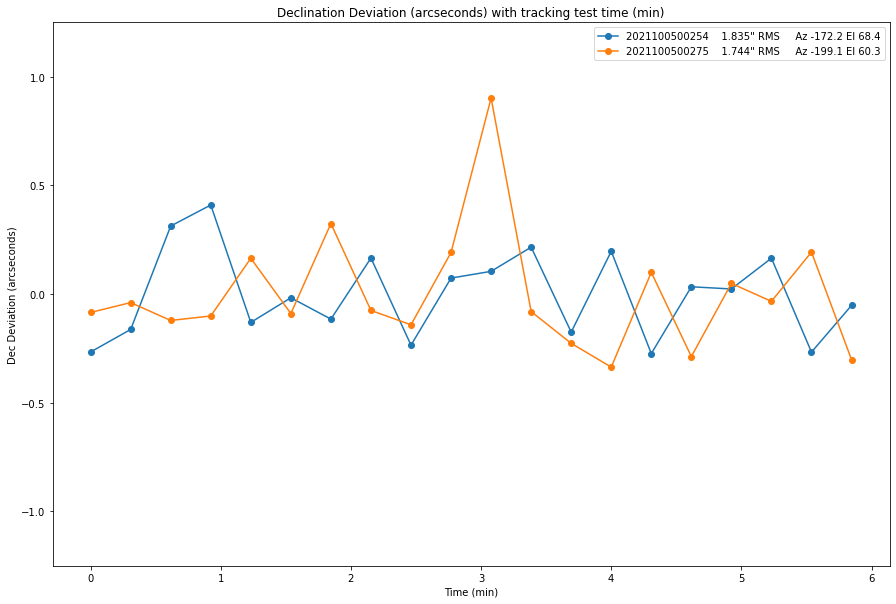

In [44]:
fig, ax = plt.subplots(figsize=(15,10))

for exposure in trackingTestswithRMS:
    firstExpId = str(exposure[0])

    ras = np.array(posData[firstExpId]['RA'])
    decs = np.array(posData[firstExpId]['Dec'])
    meanra = ras.mean()
    meandec = decs.mean()
    ra_deviation = (ras - meanra) * 3600.0
    dec_deviation = (decs - meandec) * 3600.0    
    
    ax.plot(dec_deviation, label = ('{}    {}\" RMS     Az {} El {}'.format(firstExpId, exposure[2], round(posData[firstExpId]['Azimuth'][0],1), round(posData[firstExpId]['Elevation'][0],1))), marker = 'o')
    ax.set_ylabel("Dec Deviation (arcseconds)")    
    ax.set_xlabel("Time (min)")
    ax.legend()
    ax.set_ylim(-1.25,1.25)

    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3.25))
    plt.title('Declination Deviation (arcseconds) with tracking test time (min)')

    
    a=ax.get_xticks().tolist()
    a = [-9999, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9999]
    ax.set_xticklabels(a)

plt.savefig('Dec Deviation vs Time.jpg')